In [3]:
import pandas as pd
import openpyxl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:

# Directory where your Excel files are stored
directory = 'Poverty_Data'

# List to store DataFrames from each file
dfs = []

# List of main categories
main_categories = ['AGE', 'SEX', 'RACE AND HISPANIC OR LATINO ORIGIN', 'EDUCATIONAL ATTAINMENT', 'EMPLOYMENT STATUS','WORK EXPERIENCE','All Individuals below:','ALL INDIVIDUALS WITH INCOME BELOW THE FOLLOWING POVERTY RATIOS','UNRELATED INDIVIDUALS FOR WHOM POVERTY STATUS IS DETERMINED']

# Function to determine the category for each row
def assign_category(label):
    if label in main_categories:
        assign_category.current_category = label
    return assign_category.current_category

# Initialize a variable to keep track of the current main category outside the function
assign_category.current_category = None

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)

        # Read the Excel file from the second tab
        df = pd.read_excel(file_path, sheet_name='Data', header=2,engine='openpyxl')

        # Assign categories
        df['Category'] = df['Label'].apply(assign_category)

        # Filter rows
        df = df[df['Label'].isin(['Under 18 years', '18 to 64 years', '18 to 34 years', '35 to 64 years', '65 years and over', 
                                    'Male', 'Female','Less than high school graduate','High school graduate (includes equivalency)',
                                    "Some college, associate's degree","Bachelor's degree or higher",'Employed','Unemployed',"Asian alone",'Black or African American alone','White alone',
                                    "Native Hawaiian and Other Pacific Islander alone","Hispanic or Latino origin (of any race)",'White','American Indian and Alaska Native alone',
                                    'Black or African American','American Indian and Alaska Native','Asian','Native Hawaiian and Other Pacific Islander','Hispanic or Latino origin (of any race)',
                                    "Worked full-time, year-round in the past 12 months","Worked part-time or part-year in the past 12 months","Did not work"])]

        # Drop columns with 'Margin of Error'
        df = df[df.columns.drop(list(df.filter(regex='Margin of Error')))]

        # Rename columns
        df = df.rename(columns={'Estimate': 'Total Population', 'Estimate.1': 'Below Poverty', 'Estimate.2': '% Below Poverty'})

        # Extract the year from the file name and add as a new column
        file_name_part = filename.split('.')[0]
        df['Report'] = file_name_part

        # Convert columns to integers after removing commas
        df['Total Population'] = df['Total Population'].str.replace(',', '').astype(int)
        df['Below Poverty'] = df['Below Poverty'].str.replace(',', '').astype(int)

        # Calculate Poverty Rate
        df['Poverty Rate'] = df['Below Poverty'] / df['Total Population']

        # Add the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list
all_data = pd.concat(dfs, ignore_index=True)

# Define the mapping
label_mapping = {
    'White': 'White',
    'White alone': 'White',
    'Black or African American': 'Black or African American',
    'Black or African American alone': 'Black or African American',
    'American Indian and Alaska Native': 'American Indian and Alaska Native',
    'American Indian and Alaska Native alone': 'American Indian and Alaska Native',
    'Asian': 'Asian',
    'Asian alone': 'Asian',
    'Native Hawaiian and Other Pacific Islander': 'Native Hawaiian and Other Pacific Islander',
    'Native Hawaiian and Other Pacific Islander alone': 'Native Hawaiian and Other Pacific Islander',
    'Some other race': 'Other Race',
    'Some other race alone': 'Other Race',
    'Hispanic or Latino origin (of any race)': 'Hispanic or Latino'
}

# Update the 'Label' column
all_data['Label'] = all_data['Label'].map(label_mapping).fillna(all_data['Label'])

# Convert 'Report' to datetime and set to the end of the year
all_data['Year'] = pd.to_datetime(all_data['Report'].str[-4:], format='%Y') + pd.offsets.YearEnd(0)

# Fill potentially missing data
all_data['Total Population'] = all_data['Total Population'].fillna(0)
all_data['Below Poverty'] = all_data['Below Poverty'].fillna(0)

# Additional processing if needed
all_data['Poverty Rate'] = all_data['Below Poverty']/all_data['Total Population']

all_data.head()


,Label,Total Population,Below Poverty,% Below Poverty,Category,Report,Poverty Rate,Year
0,Under 18 years,73024577,15749129,21.6%,AGE,ACSST1Y2010,0.215669,2010-12-31
1,18 to 64 years,189378803,26929254,14.2%,AGE,ACSST1Y2010,0.142198,2010-12-31
2,65 years and over,39131641,3537573,9.0%,AGE,ACSST1Y2010,0.090402,2010-12-31
3,Male,147399161,20850219,14.1%,SEX,ACSST1Y2010,0.141454,2010-12-31
4,Female,154135860,25365737,16.5%,SEX,ACSST1Y2010,0.164567,2010-12-31


In [5]:
all_data_employment_highlevel = all_data[(all_data['Category'] == 'EMPLOYMENT STATUS') & (all_data['Label'].isin(['Employed','Unemployed']))]
all_data_employment_lowlevel = all_data[(all_data['Category'] == 'WORK EXPERIENCE') & (all_data['Label'].isin(["Worked full-time, year-round in the past 12 months","Worked part-time or part-year in the past 12 months","Did not work"]))]


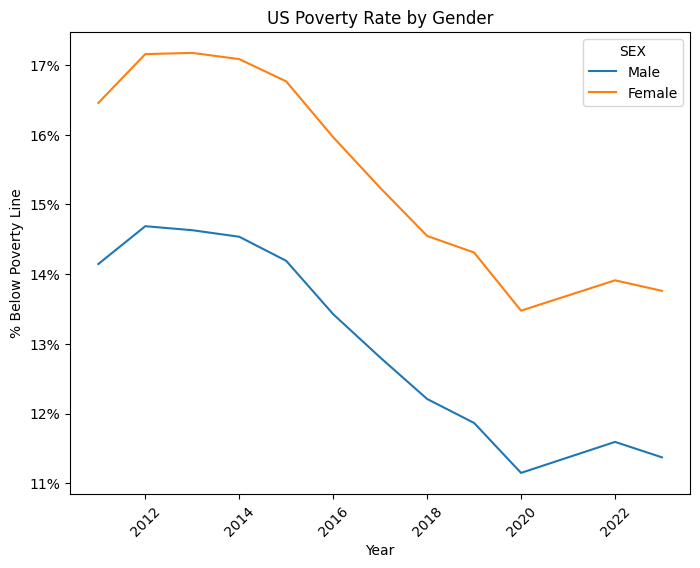

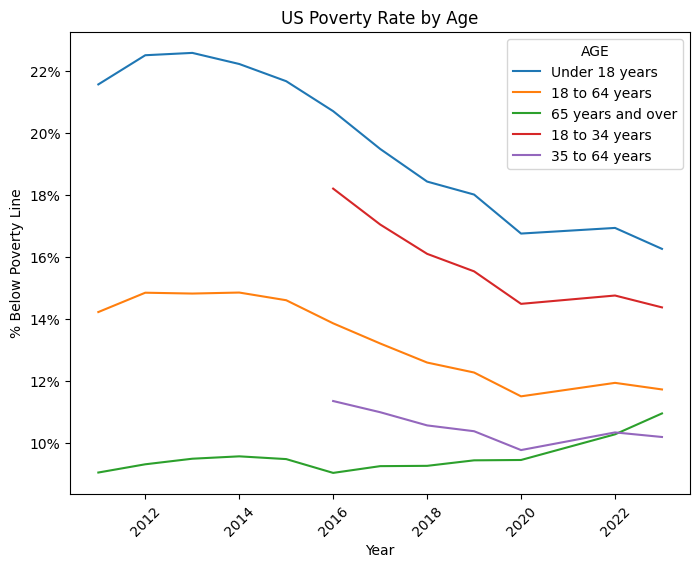

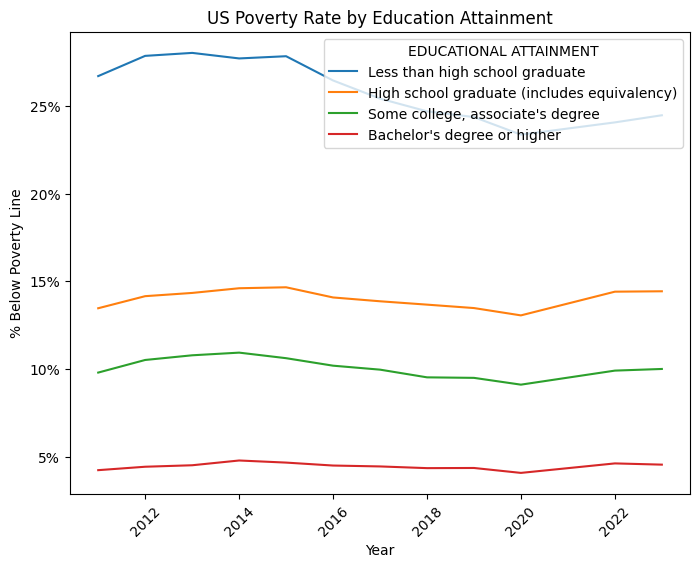

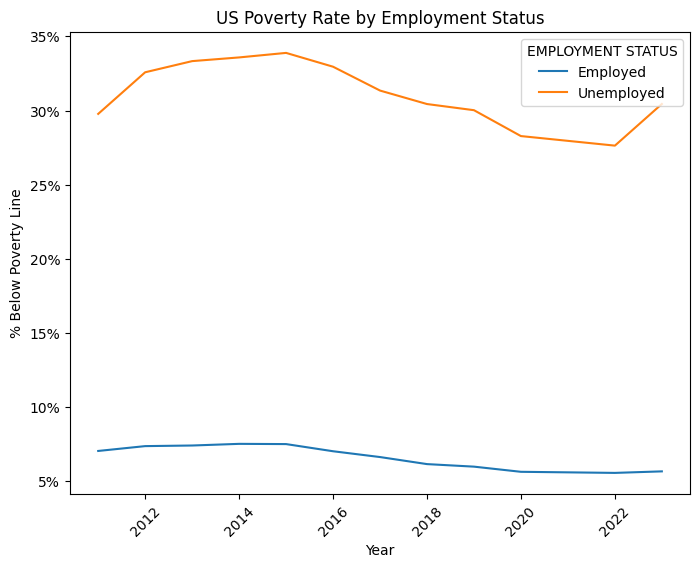

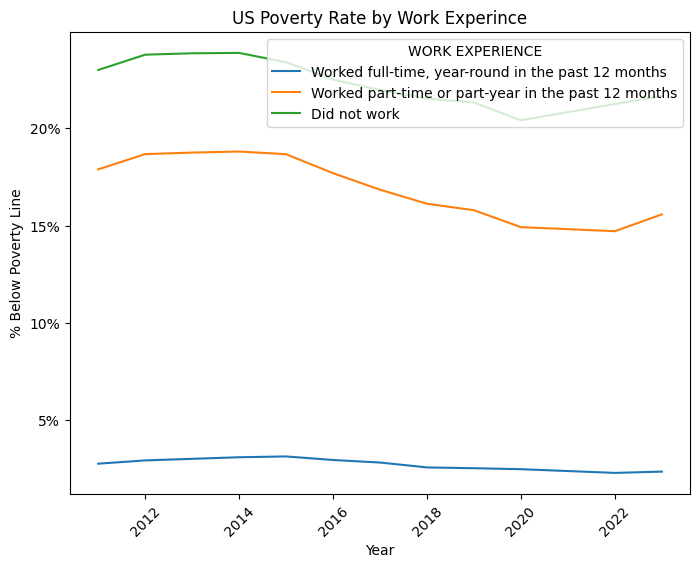

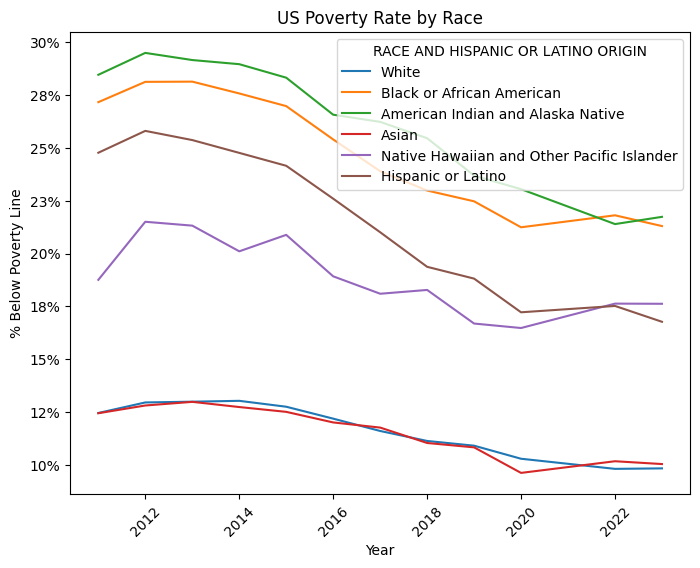

In [6]:
def plot_trend(data, category, title, palette=None):
    filtered_data = data[data['Category'] == category]

    plt.figure(figsize=(8, 6))
    
    # Create the trend plot with the specified palette
    sns.lineplot(data=filtered_data, x='Year', y='Poverty Rate', hue='Label', palette=palette)

    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('% Below Poverty Line')

    # Format the y-axis as percentages without extra decimal
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    plt.xticks(rotation=45)
    plt.legend(title=category, loc='upper right')
    plt.show()

# Example usage:
plot_trend(all_data, 'SEX', 'US Poverty Rate by Gender')
plot_trend(all_data, 'AGE', 'US Poverty Rate by Age')
plot_trend(all_data, 'EDUCATIONAL ATTAINMENT', 'US Poverty Rate by Education Attainment')
plot_trend(all_data_employment_highlevel, 'EMPLOYMENT STATUS', 'US Poverty Rate by Employment Status')
plot_trend(all_data_employment_lowlevel, 'WORK EXPERIENCE', 'US Poverty Rate by Work Experince')
plot_trend(all_data, 'RACE AND HISPANIC OR LATINO ORIGIN', 'US Poverty Rate by Race')

In [ ]:
race_df = all_data[(all_data['Category'] == 'RACE AND HISPANIC OR LATINO ORIGIN') & (all_data['Year'].dt.year == 2022)]

total_population = race_df['Total Population'].sum()
total_in_poverty = race_df['Below Poverty'].sum()

# Step 3: Calculate percentages
race_df['Race to Total Population'] = (race_df['Total Population'] / total_population) 
race_df["Race to Total in Poverty"] = (race_df['Below Poverty'] / total_in_poverty)


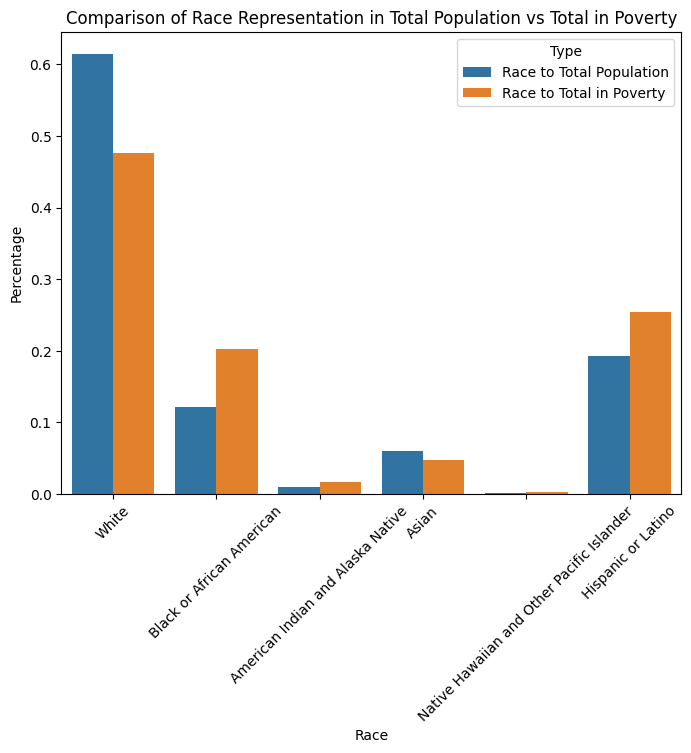

In [22]:

# Reshape the DataFrame
melted_data = race_df.melt(id_vars=['Label'], value_vars=['Race to Total Population', 'Race to Total in Poverty'], 
                               var_name='Type', value_name='Percentage')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Label', y='Percentage', hue='Type', data=melted_data)

# Adding labels and titles
plt.title('Comparison of Race Representation in Total Population vs Total in Poverty')
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.show()
